# Выбор локации для скважины

# Подготовка

Для начала импортируем необходимые для работы библиотеки

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

Создадим для удобства константы, которые будут общими и неизменяемыми для всего кода

In [2]:
RS = 12345 # значение random_state для моделей обучения и разбиени выборок
STATE = np.random.RandomState(RS) # значение boostrep

ONE_BARREL_COST = 450 # стоимость одного барреля сырья
ONE_GOOD_PROFIT = 450e3 # стоимость единицы продукта
BUDGET = 10e9 # бюджет на разработу скважин в регионе
WELL_COUNTS = 500 # количество скважин для исследования региона
BEST_WELL_COUNTS = 200 # количество лучших скважин для разработки
CONF_INTERVAL = .95 # доверительный интервал
LOSS_PROBABILITY = .025 # процент вероятности убытков

## Загрузка и подготовка данных

Для начала и для простоты пропишем функцию для получения первичных данных о таблице

In [3]:
def first_step_info(dataframe):
    column = dataframe.columns.values.tolist() # список наименований столбцов таблицы
    print('Общая информация о таблице:\n')
    dataframe.info() # общая иноформация о таблице
    print('\nВнешний вид таблицы:')
    display(dataframe.head()) # внешний вид первых 5 строк таблицы

    # далее выводим все интересующие нас особенности таблицы, соответствнно, обозначенные в функции print()
    print('Столбцы таблицы: {}\n'.format(column),
          '\n\nОбщее количество уникальных значений столбцов {}:\n\n{}'.
          format(column, dataframe.nunique()),
          '\n\nКоличество пропущенных значений столбцов {}:\n\n{}'.
          format(column, dataframe.isna().sum()))
    
    for i in column: # создадим цикл для перебора значений столбцов для отдельного примнения к ним любой функции
          print('\n\nКоличество явных дубликатов столбца:\n{}\t   {}'.format(i, dataframe[i].duplicated().sum()))
    
    print('\n\nТаблица корреляций значений столбцов {}:\n\n{}'.format(column, dataframe.corr()), '\n',
          '\n\nТаблица распределений значений столбцов {}:\n\n{}'.format(column, dataframe.describe()), '\n')
    print('Гистограммы распределений значений столбцов {}'.format(column))
    dataframe.hist(bins=50, figsize=(15, 7), edgecolor = 'k')

Можно приступить к знакомству с каджой таблицей отдельно

In [4]:
gd0 = pd.read_csv('/datasets/geo_data_0.csv')

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Внешний вид таблицы:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Столбцы таблицы: ['id', 'f0', 'f1', 'f2', 'product']
 

Общее количество уникальных значений столбцов ['id', 'f0', 'f1', 'f2', 'product']:

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64 

Количество пропущенных значений столбцов ['id', 'f0', 'f1', 'f2', 'product']:

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество явных дубликатов столбца:
id	   10


Количество явных дубликатов столбца:
f0	   0


Количество явных дубликатов столбца:
f1	   0


Количество явных дубликатов столбца:
f2	   0


Количество явных дубликатов столбца:
product	   0


Таблица корреляций значений столбцов ['id', 'f0', 'f1', 'f2', 'product']:

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000 
 

Таблица распределений значений столб

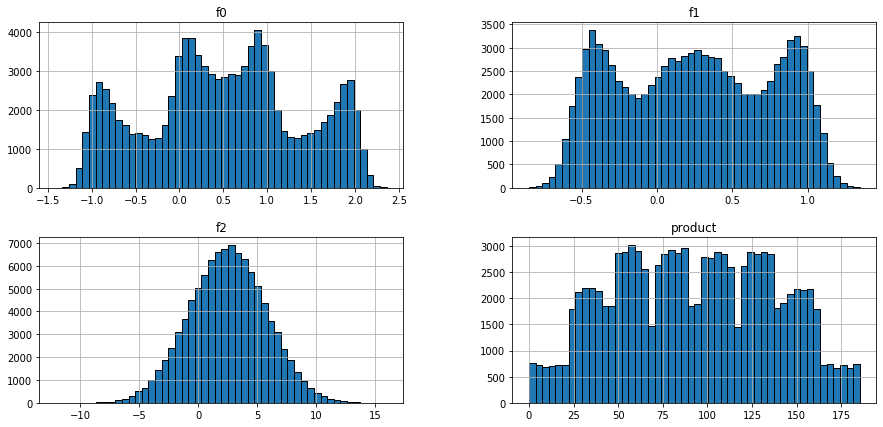

In [5]:
first_step_info(gd0) # применяем нашу функцию

**Промежуточные выводы**:  первая таблица состоит из 100 000 строк и 5 столбцов. В ней содержатся столбцы `id`, `f0`, `f1`, `f2`, `product`. Данные представленны типами object (`id`) и float (все остальные). Значения столбца `id` представляют собой случайный набор символов. По количеству уникальных значений столбца `id` можно отметить, что среди них имеются дубликаты названий (10 значений), что подтверждается далее. По таблице корреляций можно отметить некоторую связь столбца `f2` со стобцом `product`. По таблицам распределения и их гистограмам можно отметить отличающиеся от нормального распределения графики и значения.

In [6]:
gd1 = pd.read_csv('/datasets/geo_data_1.csv')

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Внешний вид таблицы:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Столбцы таблицы: ['id', 'f0', 'f1', 'f2', 'product']
 

Общее количество уникальных значений столбцов ['id', 'f0', 'f1', 'f2', 'product']:

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64 

Количество пропущенных значений столбцов ['id', 'f0', 'f1', 'f2', 'product']:

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество явных дубликатов столбца:
id	   4


Количество явных дубликатов столбца:
f0	   0


Количество явных дубликатов столбца:
f1	   0


Количество явных дубликатов столбца:
f2	   0


Количество явных дубликатов столбца:
product	   99988


Таблица корреляций значений столбцов ['id', 'f0', 'f1', 'f2', 'product']:

               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000 
 

Таблица распределений значений ст

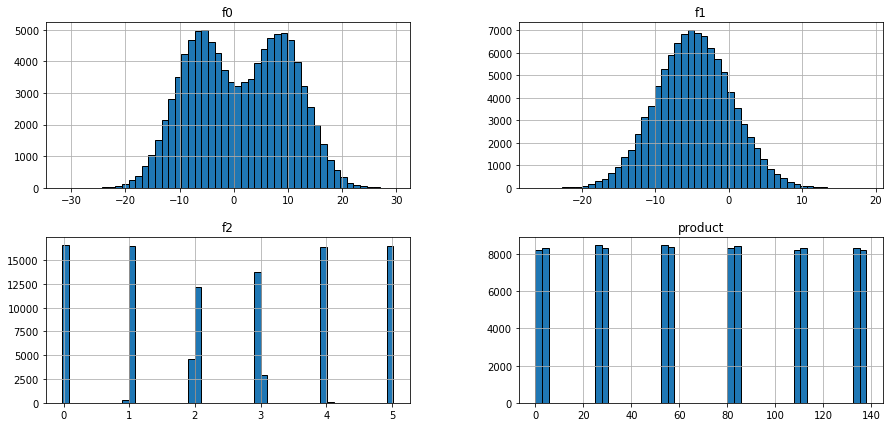

In [7]:
first_step_info(gd1)

**Промежуточные выводы**:  вторая таблица состоит из 100 000 строк и 5 столбцов. В ней содержатся столбцы `id`, `f0`, `f1`, `f2`, `product`. Данные представленны типами object (`id`) и float (все остальные). Значения столбца 'id' представляют собой случайный набор символов. По количеству уникальных значений столбца `id` можно отметить, что среди них имеются дубликаты названий (4 значения), что подтверждается далее. По таблице корреляций можно отметить прямую связь столбца `f2` со стобцом `product`. По таблицам распределения и их гистограмам можно отметить отличающиеся от нормального распределения графики и значения.

In [8]:
gd2 = pd.read_csv('/datasets/geo_data_2.csv')

Общая информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Внешний вид таблицы:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Столбцы таблицы: ['id', 'f0', 'f1', 'f2', 'product']
 

Общее количество уникальных значений столбцов ['id', 'f0', 'f1', 'f2', 'product']:

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64 

Количество пропущенных значений столбцов ['id', 'f0', 'f1', 'f2', 'product']:

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество явных дубликатов столбца:
id	   4


Количество явных дубликатов столбца:
f0	   0


Количество явных дубликатов столбца:
f1	   0


Количество явных дубликатов столбца:
f2	   0


Количество явных дубликатов столбца:
product	   0


Таблица корреляций значений столбцов ['id', 'f0', 'f1', 'f2', 'product']:

               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000 
 

Таблица распределений значений столбц

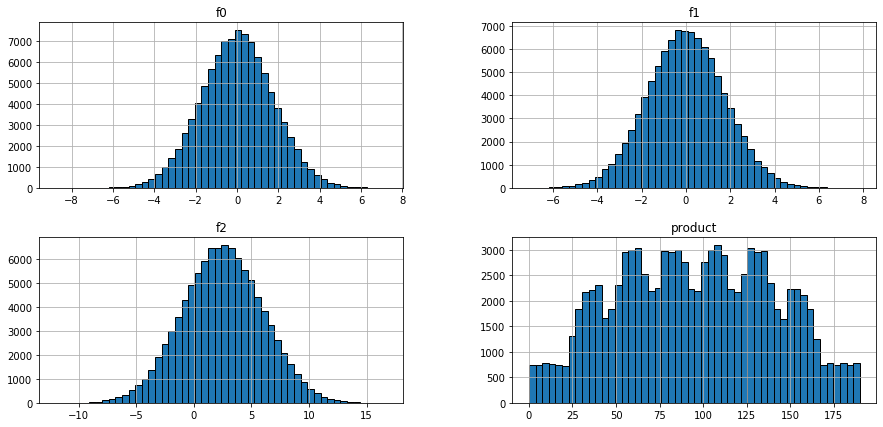

In [9]:
first_step_info(gd2)

**Промежуточные выводы**:  третья таблица также состоит из 100 000 строк и 5 столбцов. В ней содержатся столбцы `id`, `f0`, `f1`, `f2`, `product`. Данные представленны типами object (`id`) и float (все остальные). Значения столбца 'id' представляют собой случайный набор символов. По количеству уникальных значений столбца 'id' можно отметить, что среди них имеются дубликаты названий (4 значения), что подтверждается далее. По таблице корреляций можно отметить слабую, но все же более заметную связь столбца `f2` со стобцом `product`. По таблицам распределения и их гистограмам можно отметить преобладание нормального распределения для трех столбцов, кроме столбца `product`.

**Выводы**: на первый взгляд по таблицам видно, что есть дубликаты названий скважин в таблице, но строчки явно не дублируются - избавляться от них не стоит, явных пропусков не имеется, отсутствуют значения NaN. Помимо этого, видно, что имеется разброс значений в каждом столбце, что треубет применения масштабирования признаков в будущем.

## Обучение и проверка модели

Перед применением масштабирования данных, необходимо создать фильтрованную выборку.

In [10]:
gd0_filtered = gd0[['f0', 'f1', 'f2', 'product']]
gd1_filtered = gd1[['f0', 'f1', 'f2', 'product']]
gd2_filtered = gd2[['f0', 'f1', 'f2', 'product']]

Разделим таблицы на целевой признак и признаки для обучения

In [11]:
features_0 = gd0_filtered.drop('product', axis=1)
target_0 = gd0_filtered['product']

features_1 = gd1_filtered.drop('product', axis=1)
target_1 = gd1_filtered['product']

features_2 = gd2_filtered.drop('product', axis=1)
target_2 = gd2_filtered['product']

Разбиваем выборки на валидационную и обучающую.

In [12]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=RS)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=RS)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=RS)

Применим нормализацию признаков

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(features_train_0)

features_train_0_scaled = scaler.transform(features_train_0)
features_valid_0_scaled = scaler.transform(features_valid_0)

scaler.fit(features_train_1)

features_train_1_scaled = scaler.transform(features_train_1)
features_valid_1_scaled = scaler.transform(features_valid_1)

scaler.fit(features_train_2)

features_train_2_scaled = scaler.transform(features_train_2)
features_valid_2_scaled = scaler.transform(features_valid_2)


Создадим список выборок для дальнейшего применения в функции подсчета значений RMSE, создания предсказания и получения средних значений предсказанной модели

In [14]:
# списки выборок для обучения
params_to_fit_0 = [features_train_0_scaled, target_train_0,
                   features_valid_0_scaled, target_valid_0]
params_to_fit_1 = [features_train_1_scaled, target_train_1,
                   features_valid_1_scaled, target_valid_1]
params_to_fit_2 = [features_train_2_scaled, target_train_2,
                   features_valid_2_scaled, target_valid_2]

Создадим две функции: для подсчета среднеквадратичной ошибки и функцию, которая принимает на вход модель для обучения и параметры выборок (`params_to_fit`), которая на выходе отдаст нам два результата. Первый результат это таблица значений RMSE и средних значений предсказаний; второй - сами предсказания для региона выборки

In [15]:
# функция для подсчета значения RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# функция подсчета значений RMSE и средних предсказаний
def fit_and_evaluate(model, param_list):
    # созадим пустой словарь, в который будем записывать 
    # значения, полученные в ходе вычислений
    
    rmse_mean_table = defaultdict(list)
    
    # обучаем модель
    model.fit(param_list[0], param_list[1])
    
    # создание предсказаний модели и подсчет ошибки
    model_pred = model.predict(param_list[2])
    model_rmse = rmse(param_list[3], model_pred)
    
    # создание Series предсказаний для удобства подсчета
    model_pred = pd.Series(model_pred)
    
    # добавление в пустой словарь важных для нас значений:
    
    # среднего значения предсказаний модели
    rmse_mean_table['mean_predictions'].append(model_pred.mean())
    
    # значений среднеквадратичной ошибки
    rmse_mean_table['rmse'].append(model_rmse)

    # return the performance metric
    return pd.DataFrame(rmse_mean_table), model_pred

После создания функции для подсчета необходимых нам значений, применим их. Для работы используем модель линейной регрессии с параметром `n_jobs=-1`, для ускорения подсчета.

In [16]:
model = LinearRegression(n_jobs=-1)

result_predict_0 = fit_and_evaluate(model, params_to_fit_0)
result_predict_1 = fit_and_evaluate(model, params_to_fit_1)
result_predict_2 = fit_and_evaluate(model, params_to_fit_2)

# запишем сразу все значения работы модели в таблицу
rmse_mean_results_table = pd.concat([result_predict_0[0],
                                     result_predict_1[0],
                                     result_predict_2[0]]).reset_index(drop=True)

# добавим пояснения к таблице
rmse_mean_results_table['region'] = ['first_region', 
                                     'second_region', 
                                     'third_region']

Запишем предсказания работы модели в соотвествующих переменных

In [17]:
predictions_0 = result_predict_0[1]
predictions_1 = result_predict_1[1]
predictions_2 = result_predict_2[1]

А также запишем их средние значения в соответствующих переменных для удобства сравнения их с другими параметрами в будущем

In [18]:
predictions_0_mean = round(predictions_0.mean(), 2)
predictions_1_mean = round(predictions_1.mean(), 2)
predictions_2_mean = round(predictions_2.mean(), 2)

Выведем результат работы нашей модели в виде таблицы

In [19]:
 display('Таблица средних значений предсказаний и RMSE', 
         rmse_mean_results_table)

'Таблица средних значений предсказаний и RMSE'

,mean_predictions,rmse,region
0,92.592568,37.579422,first_region
1,68.728547,0.893099,second_region
2,94.965046,40.029709,third_region


**Выводы**: как видим, в связи с высокой (практически равной единице) корреляции значаний параметра `f2` со значением `product` в таблице второго региона (`second region`) (см. выше предвартительный анализ таблиц), получилось очень низкое значение ошибки для предсказания. И в то же время, видно, что среднее значение предсказаний объема запасов второго региона ниже, чем в двух других регионах.

## Подготовка к расчёту прибыли

Рассчитаем объем сырья для разработки в регионе

In [20]:
min_well_counts = round(BUDGET / ONE_GOOD_PROFIT, 2)
print('Минимальный объем сырья для разработки:', min_well_counts)

Минимальный объем сырья для разработки: 22222.22


С учетом определенного минимального объема сырья для разработки необходимо определеть наиболее выгодный район для разработки с учетом разработки 200 скважин. Для этого определим среднее значением 200 максимально насыщенных сырьем скважин в каждом регионе.

In [21]:
top_predictions_mean = pd.DataFrame({'regions': ['first_region', 'second_region', 'third_region'], 
                                     'top_predictions_mean': [target_0.mean() * 200,
                                                              target_1.mean() * 200,
                                                              target_2.mean() * 200],
                                     'minimal_barrels': min_well_counts,
                                     'mean_delta': [target_0.mean() * 200 - min_well_counts,
                                                    target_1.mean() * 200 - min_well_counts,
                                                    target_2.mean() * 200 - min_well_counts]})

top_predictions_mean

,regions,top_predictions_mean,minimal_barrels,mean_delta
0,first_region,18500.0,22222.22,-3722.22
1,second_region,13765.0,22222.22,-8457.22
2,third_region,19000.0,22222.22,-3222.22


**Промежуточный вывод**: наиболее богатый регион по содержанию сырья - третий регион

Напишем функцию для подсчета прибыли с учетом требований и исходных данных

In [22]:
# функция для посчета выручки, принимающая на вход
# значения целевого признака валиадционной выборки,
# предсказания модели и значения количества исследований
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    # сумма подсчета выручки
    profit = ((target.loc[probs_sorted.index][:count] * 
               ONE_BARREL_COST * 1000).sum() -
               BUDGET)
    return profit

In [23]:
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)

**Выводы**: минимальный объем сырья для безубыточной разработки новой скважины меньше средних значений объема сырья для каждого региона. Таким образом, все регионы для разработки безубыточны, согласно предсказаниям модели. Создана функция для подсчета общей выручки. Данные подготовлены для дальнейших подсчетов.


## Расчёт прибыли и рисков 

Для рассчета прибыли и рисков для каждого региона пропишем функцию `boots`, в которой применим метод `bootstrep`, многократно (`1000` раз) проверив выборку из 500 точек (`WELL_COUNTS`) скважин, отобрав лучшие 200 (`BEST_WELL_COUNTS`). Помимо этого выберем результаты наших подсчетов в требуемом доверительном интервале (`CONF_INTERVAL`). Результаты работы функции также поместим в таблицу (`results`) и выведем значения подсчетов подбора лучших значений каждой скважины каждого региона (`values`).

In [24]:
# функия подсчета прибыли для каждого региона и 
# извлечения значений прибыли для каждого региона
def boots(target, probabilities):
    
    # созадим пустой словарь, в который будем записывать 
    # значения, полученные в ходе вычислений
    results = defaultdict(list)
    
    #создадим пустой список для зeаполнения значениями прибыли
    values = []
    
    # цикл перебора значений для bootstrep подсчета прибыли
    for i in range(1000):
        target_subsample = target.sample(n=WELL_COUNTS, replace=True, random_state=STATE)
        probs_subsample = probabilities.loc[target_subsample.index]
        values.append(round(profit(target_subsample, probs_subsample, BEST_WELL_COUNTS), 2))

    values = pd.Series(values)
    
    # сформируем довертиельный интервал
    lower = (1 - CONF_INTERVAL) / 2
    upper = (1 + CONF_INTERVAL) / 2
    
    # переменная средних значений прибыли с каждого перебора
    mean = round(values.mean(), 2)
    
    # добавление в словарь интересующие нас значения:
    
    # средних значений прибыли
    results['mean_value'].append(mean)
    
    # доверительного интервала
    results['lower_upper_interval'].append((values.quantile(lower),
                                            values.quantile(upper)))
    # среднего стандартного отклонения
    results['std'].append(values.std())
    
    # подсчет убыточных значений при разработке скважин
    less_zero = 0
    for i in values:
        if i < 0:
            less_zero += 1
            
    results['negative profit'].append(less_zero/len(values))
    
    # возвращаем таблицу результатов и список значений прибыли
    return (pd.DataFrame(results), values)


Применим нашу функцию подсчета прибыли к для каждого региона и сохраним их в отдельной переменной с дальнейшим занесением их результутов в таблицу

In [25]:
profit_0 = boots(target_valid_0, predictions_0)
profit_1 = boots(target_valid_1, predictions_1)
profit_2 = boots(target_valid_2, predictions_2)

# создадим таблицу из полученных значений
final_results_table = (pd.concat([profit_0[0], 
                                 profit_1[0], 
                                 profit_2[0]]).
                       reset_index(drop=True))
final_results_table['region'] = ['first_region', 
                                 'second_region', 
                                 'third_region']

# и выведем таблицу на экран
final_results_table

,mean_value,lower_upper_interval,std,negative profit,region
0,4.259385e+08,"(-102090094.84224996, 947976353.3625)",2.772767e+08,0.060,first_region
1,5.182595e+08,"(128123231.43, 953612982.0642499)",2.096475e+08,0.003,second_region
2,4.201940e+08,"(-115852609.1557499, 989629939.84725)",2.846731e+08,0.062,third_region


**Промежуточные выводы**: как видим, средний разброс значений прибыли у каждого региона схож, однако у третьего региона он меньше всех, что более предпочтительно и выгодней. Помимо этого, среднее значение выручки в третеьм регионе выше остальных.

Запишем значения прибыли каждого региона в соответствующую переменную

In [26]:
reg0 = profit_0[1]
reg1 = profit_1[1]
reg2 = profit_2[1]

Посторим гистограммы распределния прибыли по каждому региону

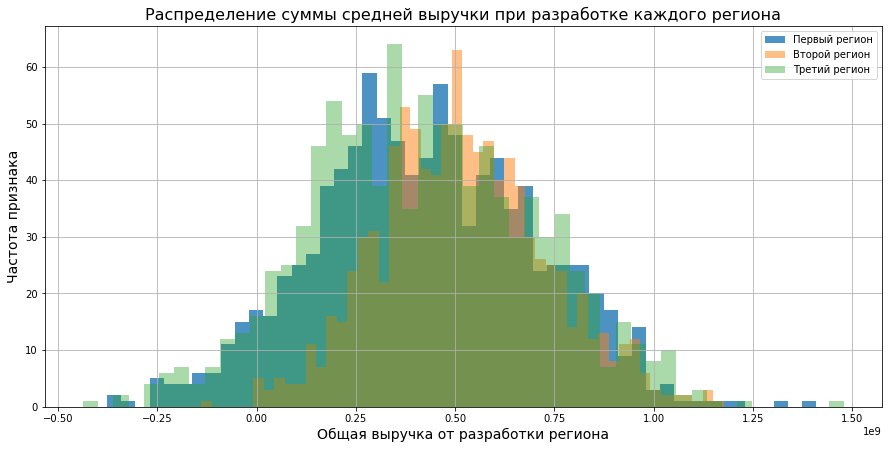

In [27]:
reg0.plot(kind='hist', bins=50, figsize=(15, 7), label='Первый регион', alpha=0.8)
reg1.plot(kind='hist', bins=50, figsize=(15, 7), label='Второй регион', alpha=0.5)
reg2.plot(kind='hist', bins=50, figsize=(15, 7), label='Третий регион', alpha=0.4)

plt.grid(True)
plt.legend()
plt.title('Распределение суммы средней выручки при разработке каждого региона', fontsize=16)
plt.ylabel('Частота признака', fontsize=14)
plt.xlabel('Общая выручка от разработки региона', fontsize=14)
plt.show()


Гистограммы оказались не очень наглядны, воспользуемся другой визуализацией проверки распределения, где можно увидеть "колокол" распределения прибили регионов

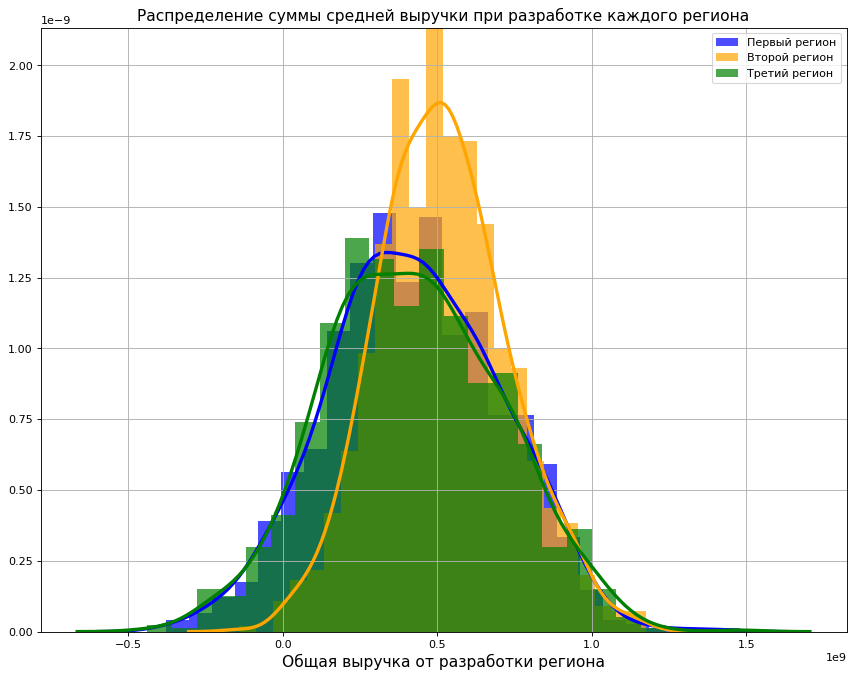

In [28]:
plt.figure(figsize=(13,10), dpi= 80)
sns.distplot(reg0, color='blue', label='Первый регион', hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(reg1, color='orange', label='Второй регион', hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(reg2, color='g', label='Третий регион', hist_kws={'alpha':.7}, kde_kws={'linewidth':3})

plt.grid(True)
plt.title('Распределение суммы средней выручки при разработке каждого региона', fontsize=14)
plt.xlabel('Общая выручка от разработки региона', fontsize=14)
plt.legend()
plt.show()


**Выводы**: графики схожи, но здесь также видно, что график 2 региона имеет большую прибыль по сравнению со первым и третьим регионом. При этом можно отметить, что самый узкий разброс средних значений соответствует распределению прибыли 1 региона. Таким образом, предпочтительным регионом для разработки следует выбрать второй регион с точки зрения прибыли.

# Общие выводы

В ходе работы было проделано следующее.

1. Ознакомеление с данными (для удобства была создана функция извлечения общей информации о данных):
 - данные представляют собой схожие таблицы, в которых каждая состоит из 100 000 строк и 5 столбцов, в них содержатся столбцы `id`, `f0`, `f1`, `f2`, `product`. Данные представленны типами object (`id`) и float (все остальные). Значения столбца 'id' представляют собой случайный набор символов.
 - во второй таблице отмечена прямая корреляция параметра `f2` и `product`
 - в таблицах не выявлено явных дубликатов, явных пропусков, отсутствуют значения NaN
 - выявлен разброс значений в каждом столбце, на основании чего было принято решение применения масштабирования признаков, а именно нормализации
 
2. Было выполнено фильтрование таблиц для нормализация значений столбцов, произведено деление на тренировочную и валидационную выборку, произведена нормализация признаков, произведено обучение модели с выделением средних значений объемов сырья в каждом регионе, с подсчетом значений RMSE. Было выяснено следующее:
 - в таблице второго региона (`second region`) модель обучения имеет очень низкое значение ошибки для предсказания. 
 - среднее значение предсказаний объема запасов второго региона ниже, чем в двух других регионах
 - наибольшее значение объемов сырья имеет третий регион, но значение ошибки предсказания модели также наиболее велико
 
3. Произведерн подсчет наименьшего  объема сырья для безубыточной разработки, который соответствует 49.38 тыс. баррелей, из чего слеудет, что безубыточная разработка может идти в каждом регионе. 

4. Произведен подсчет прибыли для каждого региона с учетом подсчета рисков и доверительного интервала 95%-значения. Выявлено:
 - наименьший разброс значений прибыли соответсвует разработке во втором регионе;
 - наибольшая прибыль возможна во регионе;
 - наиболее точные предсказания модели для получения прибыли соответствует второму региону.
 